In [1]:
import networkx as nx
import numpy as np
import pandas as pd
from networkx.readwrite import json_graph
import json
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import math

from time import time
from datetime import timedelta, datetime
from copy import deepcopy, copy
from __future__ import division
from custom_funcs import *

In [2]:
# Load the data
starttime = time()
data = pd.read_csv('3.0 - Transmissions/Minto Plus North America All Transmissions.csv', index_col=0, parse_dates=['Collection Date', 'Collection Date2'])
data['Time Delta'] = data['Collection Date2'] - data['Collection Date']
data['Time Delta'] = data['Time Delta'].astype('timedelta64[D]')
endtime = time()
print('%s seconds' % (endtime - starttime))
# Longest recorded time: 18 seconds.
len(data)

16.3024377823 seconds


3191582

In [3]:
# There should be 1186 isolates.
# 22 September 2014: After filtering out isolates from 2011, there are only 1169 isolates, consistent with what I had
# counted when doing data removal earlier on.
# 23 September 2014: After chat with Nichola, we are including everything from 2008 to 2011. There should be 1756 isolates.
# 25 September 2014: Update - after figuring out how many isolates were dropped incorrectly, there should be 1787 isoaltes
len(data.groupby('Isolate1'))

1787

In [4]:
# Initialize the graph that will be used to store the transmission network
G = nx.DiGraph()

# Initialize a graph that will hold all of the discarded edges from G. This is used to
# add back edges that are sources for isolates that may have been implicated in bi-directional
# reconstructions as a result of the "-6 to +15" rule.
G_discarded = nx.DiGraph()

In [5]:
starttime = time()

# Add nodes into the graph, along with metadata.
for group in data.groupby(['Isolate1', 'Collection Date', 'Subtype', 'Host Species','State/Province']):
    G.add_node(group[0][0],
               isolation_date=group[0][1],
               subtype=group[0][2],
               host=group[0][3],
               state=group[0][4])
    
for group in data.groupby(['Isolate2', 'Collection Date2', 'Subtype2', 'Host Species2','State/Province2']):
    G.add_node(group[0][0],
               isolation_date=group[0][1],
               subtype=group[0][2],
               host=group[0][3],
               state=group[0][4])

endtime = time()
print('%s seconds' % (endtime - starttime))

# Longest recorded time: 6 seconds.

5.9230120182 seconds


In [6]:
# Inspect the first node to make sure the data were entered correctly.
G.nodes(data=True)[1]

('A/mallard/California/2542V/2011',
 {'host': 'IRD:Mallard/Avian',
  'isolation_date': Timestamp('2011-08-12 00:00:00'),
  'state': 'California',
  'subtype': 'H5N1'})

In [7]:
# There should be the same number of nodes as in the cell with len(data.groupby("Isolate1")).
len(G.nodes())

1787

In [8]:
# There should be no edges right now.
G.edges(data=True)

[]

In [9]:
data[(data['PWI'] > 7) & \
     ((data['Isolate2'] == 'A/mallard/Interior Alaska/10BM05860R0/2010') |\
      (data['Isolate1'] == 'A/mallard/Interior Alaska/10BM05860R0/2010')) &\
     (data['Time Delta'] >= -6)]

,Isolate2,Isolate1,PWI,Collection Date,Host Species,Subtype,Country,State/Province,Collection Date2,Host Species2,Subtype2,Country2,State/Province2,Time Delta,State/Province1
1152616,A/mallard/Interior Alaska/10BM05347R0/2010,A/mallard/Interior Alaska/10BM05860R0/2010,8.000000,2010-07-26,IRD:Avian,H7N3,USA,Alaska,2010-07-25,IRD:Mallard/Avian,H7N3,USA,Interior Alaska,-1,Interior Alaska
1156187,A/mallard/Interior Alaska/10BM05860R0/2010,A/mallard/Interior Alaska/10BM05347R0/2010,8.000000,2010-07-25,IRD:Mallard/Avian,H7N3,USA,Alaska,2010-07-26,IRD:Avian,H7N3,USA,Interior Alaska,1,Interior Alaska
1156204,A/mallard/Interior Alaska/10BM05860R0/2010,A/mallard/Interior Alaska/10BM06838R0/2010,7.995546,2010-07-31,IRD:Avian,H7N3,USA,Alaska,2010-07-26,IRD:Avian,H7N3,USA,Interior Alaska,-5,Interior Alaska
1156205,A/mallard/Interior Alaska/10BM05860R0/2010,A/mallard/Interior Alaska/10BM06905R0/2010,7.996765,2010-07-31,IRD:Avian,H7N3,USA,Alaska,2010-07-26,IRD:Avian,H7N3,USA,Interior Alaska,-5,Interior Alaska
1156206,A/mallard/Interior Alaska/10BM05860R0/2010,A/mallard/Interior Alaska/10BM06909R0/2010,7.994999,2010-07-31,IRD:Avian,H7N3,USA,Alaska,2010-07-26,IRD:Avian,H7N3,USA,Interior Alaska,-5,Interior Alaska
1156207,A/mallard/Interior Alaska/10BM05860R0/2010,A/mallard/Interior Alaska/10BM06911R0/2010,7.996765,2010-07-31,IRD:Avian,H7N3,USA,Alaska,2010-07-26,IRD:Avian,H7N3,USA,Interior Alaska,-5,Interior Alaska
1156208,A/mallard/Interior Alaska/10BM05860R0/2010,A/mallard/Interior Alaska/10BM07066R0/2010,7.994803,2010-08-01,IRD:Mallard/Avian,H7N3,NaN,NaN,2010-07-26,IRD:Avian,H7N3,USA,Interior Alaska,-6,Interior Alaska
1156209,A/mallard/Interior Alaska/10BM05860R0/2010,A/mallard/Interior Alaska/10BM07072R0/2010,7.997527,2010-08-01,IRD:Mallard/Avian,H7N3,NaN,NaN,2010-07-26,IRD:Avian,H7N3,USA,Interior Alaska,-6,Interior Alaska
1156210,A/mallard/Interior Alaska/10BM05860R0/2010,A/mallard/Interior Alaska/10BM07085R0/2010,7.996179,2010-08-01,IRD:Mallard/Avian,H7N3,NaN,NaN,2010-07-26,IRD:Avian,H7N3,USA,Interior Alaska,-6,Interior Alaska
1156211,A/mallard/Interior Alaska/10BM05860R0/2010,A/mallard/Interior Alaska/10BM07092R0/2010,7.996765,2010-08-01,IRD:Mallard/Avian,H7N3,NaN,NaN,2010-07-26,IRD:Avian,H7N3,USA,Interior Alaska,-6,Interior Alaska


In [10]:
# Add in edges to the graph, and classify them as intra-species or inter-species.
for row in data[data['PWI'] > 7.0].iterrows():
    # 12 September 2014: I just noticed here that 
    #     if Time Delta >= -7 
    # should have been:
    #     if Time Delta >= -6.
    # Made the change here.
    if row[1]['Time Delta'] >= -6:
        if row[1]['Host Species'] == row[1]['Host Species2']:
            G.add_edge(row[1]['Isolate1'], 
                       row[1]['Isolate2'], 
                       time_delta=timedelta(row[1]['Time Delta']), 
                       weight=row[1]['PWI'], 
                       trtype='Intra-Species')
        if row[1]['Host Species'] != row[1]['Host Species2']:
            G.add_edge(row[1]['Isolate1'], 
                       row[1]['Isolate2'], 
                       time_delta=timedelta(row[1]['Time Delta']), 
                       weight=row[1]['PWI'], 
                       trtype='Inter-Species')

In [11]:
# Inspect the first edge in the graph, to make sure the data are added in correctly.
G.edges(data=True)[2]

('A/mallard/California/2542V/2011',
 'A/mallard/California/2531P/2011',
 {'time_delta': datetime.timedelta(0),
  'trtype': 'Intra-Species',
  'weight': 7.995221000000001})

In [12]:
len([edge for edge in G.edges() if 'A/mallard/Interior Alaska/10BM05860R0/2010' in edge])

83

In [13]:
# With Time Delta >= -7, there should be 13414 edges.
# With Time Delta >= -6, there should be 13092 edges. 
# 12 September 2014: The latter should be correct.
# 22 September 2014: With 2011 isolates filtered out, now there are only 13083 edges.
# 23 September 2014: With expanded dataset including 2008 to 2011, there are 17379 edges that involve all 8 segments and
# fulfill the time requirement
print(len(G.edges()))

18701


In [14]:
# Prune away any edges not equal to max_weight.
# Add those discarded edges to a separate graph that has 

for node in G.nodes(data=True):
    G_discarded.add_node(node[0], attr_dict=node[1])
    edges = G.in_edges(node[0], data=True)
    if len(edges) > 0:
        max_weight = max([edge[2]['weight'] for edge in edges])
        for edge in edges:
            if edge[2]['weight'] < max_weight:
                G.remove_edge(edge[0], edge[1])
                G_discarded.add_edge(edge[0], edge[1], attr_dict=edge[2])

In [15]:
[edge for edge in G.edges() if 'A/mallard/Interior Alaska/10BM05860R0/2010' in edge]

[('A/mallard/Interior Alaska/10BM05347R0/2010',
  'A/mallard/Interior Alaska/10BM05860R0/2010'),
 ('A/mallard/Interior Alaska/10BM05860R0/2010',
  'A/northern pintail/Interior Alaska/10BM08400R0/2010'),
 ('A/mallard/Interior Alaska/10BM05860R0/2010',
  'A/mallard/Interior Alaska/10BM05347R0/2010'),
 ('A/mallard/Interior Alaska/10BM05860R0/2010',
  'A/northern pintail/Interior Alaska/10BM08586R0/2010'),
 ('A/mallard/Interior Alaska/10BM05860R0/2010',
  'A/northern pintail/Interior Alaska/10BM11208R0/2010')]

In [16]:
# Inspect one of the discarded edges
G_discarded.edges(data=True)[0]

('A/mallard/California/2542V/2011',
 'A/mallard/California/2527V/2011',
 {'time_delta': datetime.timedelta(0),
  'trtype': 'Intra-Species',
  'weight': 7.996829999999999})

In [17]:
# Check to see how many discarded edges are present
len(G_discarded.edges())

16779

In [18]:
# Check to see that the number of discarded edges and the number of retained edges = original # of edges (i.e. 13083)
# 23 September 2014: Update - should be 17379
len(G_discarded.edges()) + len(G.edges())

18701

In [19]:
# This cell is used for querying the data, to make sure that the edges are correct.
G.in_edges('A/ruddy turnstone/New Jersey/AI09-775/2009', data=True)
# G.edges(['A/American green-winged teal/Interior Alaska/10BM04207R0/2010'], data=True)

[('A/ruddy turnstone/New Jersey/AI09-841/2009',
  'A/ruddy turnstone/New Jersey/AI09-775/2009',
  {'time_delta': datetime.timedelta(7),
   'trtype': 'Intra-Species',
   'weight': 7.995798})]

In [20]:
# Identify the potential reassortants in the graph. 
# These guys are the ones without any in_edges going into them.
reassortants = []
for node in G.nodes():
    if len(G.in_edges(node)) == 0:
        reassortants.append(node)
pd.Series(reassortants).to_csv('Reassortants by Network Analysis.csv')

In [21]:
# There should be 1377 edges.
# 23 September 2014: There should be 1922 full transmission edges when 2008-2011 is considered.
print(len(G.edges()))

1922


In [22]:
[edge for edge in G.edges() if 'A/mallard/Interior Alaska/10BM05860R0/2010' in edge]

[('A/mallard/Interior Alaska/10BM05347R0/2010',
  'A/mallard/Interior Alaska/10BM05860R0/2010'),
 ('A/mallard/Interior Alaska/10BM05860R0/2010',
  'A/northern pintail/Interior Alaska/10BM08400R0/2010'),
 ('A/mallard/Interior Alaska/10BM05860R0/2010',
  'A/mallard/Interior Alaska/10BM05347R0/2010'),
 ('A/mallard/Interior Alaska/10BM05860R0/2010',
  'A/northern pintail/Interior Alaska/10BM08586R0/2010'),
 ('A/mallard/Interior Alaska/10BM05860R0/2010',
  'A/northern pintail/Interior Alaska/10BM11208R0/2010')]

In [23]:
len([edge for edge in G_discarded.edges() if 'A/mallard/Interior Alaska/10BM05860R0/2010' in edge])

78

In [24]:
# Check to ensure that the metadata for each node are added in correctly.
G.nodes(data=True)[15]

('A/blue-winged teal/North Dakota/Sg-00740/2008',
 {'host': 'IRD:Avian',
  'isolation_date': Timestamp('2008-09-07 00:00:00'),
  'state': 'North Dakota',
  'subtype': 'H3N8'})

In [25]:
# Sandbox cell: Check to see if we can do a "min" operation on date objects.

from datetime import date

datelist = [date(2010, 8, 12), 
            date(2010, 8, 7),
            date(2010, 7, 3)]

min(datelist)

datetime.date(2010, 7, 3)

In [26]:
# Find all subgraphs of G, and then add in edges that explain the earliest isolate of each subgraph.
# Prior to adding them back in, there should be 539 subgraphs.
# 22 September 2014: Update - after removal of 2011 isolates, there should only be 525.
starttime = time()
subgraphs = list(nx.connected_component_subgraphs(G.to_undirected()))
print("Initially, we had %s subgraphs." % len(subgraphs))

# for subgraph in subgraphs:
#     if len(subgraph.nodes()) == 1:
#         print(subgraph.nodes())

edges_to_add = []

for i in range(len(subgraphs)):
    earliest_nodes_in_subgraph = find_earliest_nodes(subgraphs[i])
    
    for node in earliest_nodes_in_subgraph:
    
        new_edges = find_source_node(node, G_discarded)
        if node[0] == 'A/mallard/Interior Alaska/10BM08884R0/2010':
            print(node)
            print(new_edges)
            
        if len(new_edges) > 0:
            edges_to_add.extend(new_edges)
G.add_edges_from(edges_to_add)


print("An additional %s edges were added back." % len(edges_to_add))
print("We now have %s edges." % len(G.edges()))
endtime = time()
print("%s seconds" % (endtime - starttime))

Initially, we had 765 subgraphs.
('A/mallard/Interior Alaska/10BM08884R0/2010', {'subtype': 'H7N3', 'host': 'IRD:Mallard/Avian', 'isolation_date': Timestamp('2010-08-05 00:00:00'), 'state': 'Interior Alaska'})
[('A/mallard/Interior Alaska/10BM05347R0/2010', 'A/mallard/Interior Alaska/10BM08884R0/2010', {'trtype': 'Intra-Species', 'weight': 7.995813, 'time_delta': datetime.timedelta(11)}), ('A/mallard/Interior Alaska/10BM05860R0/2010', 'A/mallard/Interior Alaska/10BM08884R0/2010', {'trtype': 'Inter-Species', 'weight': 7.995813, 'time_delta': datetime.timedelta(10)})]
An additional 292 edges were added back.
We now have 2214 edges.
0.405383825302 seconds


In [27]:
[edge for edge in G.edges() if 'A/mallard/Interior Alaska/10BM05860R0/2010' in edge]

[('A/mallard/Interior Alaska/10BM05347R0/2010',
  'A/mallard/Interior Alaska/10BM05860R0/2010'),
 ('A/mallard/Interior Alaska/10BM05860R0/2010',
  'A/northern pintail/Interior Alaska/10BM09348R0/2010'),
 ('A/mallard/Interior Alaska/10BM05860R0/2010',
  'A/northern pintail/Interior Alaska/10BM09481R0/2010'),
 ('A/mallard/Interior Alaska/10BM05860R0/2010',
  'A/mallard/Interior Alaska/10BM10829R0/2010'),
 ('A/mallard/Interior Alaska/10BM05860R0/2010',
  'A/mallard/Interior Alaska/10BM08884R0/2010'),
 ('A/mallard/Interior Alaska/10BM05860R0/2010',
  'A/northern pintail/Interior Alaska/10BM10801R0/2010'),
 ('A/mallard/Interior Alaska/10BM05860R0/2010',
  'A/mallard/Interior Alaska/10BM10811R0/2010'),
 ('A/mallard/Interior Alaska/10BM05860R0/2010',
  'A/northern pintail/Interior Alaska/10BM09832R0/2010'),
 ('A/mallard/Interior Alaska/10BM05860R0/2010',
  'A/northern pintail/Interior Alaska/10BM10805R0/2010'),
 ('A/mallard/Interior Alaska/10BM05860R0/2010',
  'A/northern pintail/Interior Ala

In [28]:
print(len(edges_to_add))
edges_to_add

292


[('A/American black duck/Prince Edward Island/00788/2010',
  'A/blue-winged teal/Nova Scotia/00077/2010',
  {'time_delta': datetime.timedelta(13),
   'trtype': 'Intra-Species',
   'weight': 7.999347}),
 ('A/American black duck/Prince Edward Island/00788/2010',
  'A/mallard/Nova Scotia/00778/2010',
  {'time_delta': datetime.timedelta(13),
   'trtype': 'Intra-Species',
   'weight': 7.998914999999998}),
 ('A/American black duck/Prince Edward Island/00788/2010',
  'A/blue-winged teal/Nova Scotia/00074/2010',
  {'time_delta': datetime.timedelta(13),
   'trtype': 'Intra-Species',
   'weight': 7.999347}),
 ('A/snow goose/Nunavet/03438/2010',
  'A/blue-winged teal/Nova Scotia/00072/2010',
  {'time_delta': datetime.timedelta(49),
   'trtype': 'Intra-Species',
   'weight': 7.997534}),
 ('A/snow goose/Nunavet/03438/2010',
  'A/blue-winged teal/Nova Scotia/00071/2010',
  {'time_delta': datetime.timedelta(49),
   'trtype': 'Intra-Species',
   'weight': 7.996646000000001}),
 ('A/snow goose/Nunavet/0

In [29]:
edges_to_add_list = []
for edge in edges_to_add:
    edge_dict = dict()
    edge_dict['source'] = edge[0]
    edge_dict['sink'] = edge[1]
    edge_dict['weight'] = edge[2]['weight']
    edge_dict['time_delta'] = edge[2]['time_delta']
    edges_to_add_list.append(edge_dict)
    
pd.DataFrame(edges_to_add_list).to_csv('3.10 - Edges to Add.csv')

In [30]:
# With the new edges added in, it is now 1571 edges.
# 22 September 2014: Update - with 2011 isolates removed, it is 1568
# 23 September 2014: With 2008-2011 included, it is 2223
len(G.edges(data=True))

2214

In [31]:
# After adding in more edges, the number of subgraphs becomes 474
# 22 September 2014: Update - with 2011 isolates removed, it is 460.
# 23 September 2014: Update - with 2008-2011 included, it is 686.
subgraphs = list(nx.connected_component_subgraphs(G.to_undirected()))
print(len(subgraphs))

652


In [32]:
# Classify the edges.
from datetime import timedelta
for edge in G.edges(data=True):
    if edge[2]['time_delta'] > timedelta(15):
        edge[2]['tr_timeclass'] = "Environmental Persistence"
    if edge[2]['time_delta'] <= timedelta(15):
        edge[2]['tr_timeclass'] = "Direct Transmission"

In [33]:
# Check to ensure that the time classes are added in correctly.
G.edges(data=True)[9]

('A/blue-winged teal/Wisconsin/2713/2009',
 'A/blue-winged teal/Wisconsin/2665/2009',
 {'time_delta': datetime.timedelta(0),
  'tr_timeclass': 'Direct Transmission',
  'trtype': 'Intra-Species',
  'weight': 7.9932539999999985})

In [34]:
[edge for edge in G.edges() if 'A/mallard/California/2535P/2011' in edge]

[('A/mallard/California/2536P/2011', 'A/mallard/California/2535P/2011'),
 ('A/mallard/California/2535P/2011', 'A/mallard/California/2535V/2011')]

In [35]:
# This is a custom function for serializing dates such that it is JSON compatible. 
# It gets used right at the last step prior to the JSON dump.
from dateutil.tz import tzutc

UTC = tzutc()

def serialize_date(dt):
    """
    Serialize a date/time value into an ISO8601 text representation
    adjusted (if needed) to UTC timezone.

    For instance:
    >>> serialize_date(datetime(2012, 4, 10, 22, 38, 20, 604391))
    '2012-04-10T22:38:20.604391Z'
    """
    #if dt.tzinfo:
    #    dt = dt.astimezone(UTC)
    return dt.isoformat()

In [36]:
# We do not want to consider any edges in which none of the isolates are connected to an isolate in 2009 or 2010.
# Therefore, grab out every subgraph, and if none of the isolates in the subgraph are connected to a 2009 or 2010
# isolate, then remove all nodes in that subgraph from the large graph G.

subgraphs = list(nx.connected_component_subgraphs(G.to_undirected()))

G_twoyears = G.copy()

for graph in subgraphs:
    # grab all the nodes from each subgraph
    nodes = graph.nodes(data=True)
    node_names = [node[0] for node in nodes]
    
    # grab all years from the subgraph
    dates = [node[1]['isolation_date'] for node in nodes]
    years = [date.year for date in dates]
    
    if 2009 not in years and 2010 not in years:
#         undirected_G.remove_nodes_from(node_names)
        G_twoyears.remove_nodes_from(node_names)
        print(years)
    

[2008]
[2011, 2011, 2011, 2011, 2011, 2011, 2011]
[2008, 2008, 2008, 2008, 2008, 2008, 2008, 2008, 2008, 2008, 2008, 2008, 2008]
[2008, 2008]
[2008, 2011, 2008]
[2011, 2011]
[2008, 2008, 2008, 2008, 2008, 2008, 2008, 2008, 2008, 2008]
[2008, 2008]
[2008, 2008, 2008, 2008, 2008, 2008, 2008, 2008, 2008, 2008, 2008, 2008, 2008, 2008, 2008, 2008, 2008, 2008, 2008, 2008, 2008, 2008, 2008, 2008]
[2008, 2008, 2008, 2008, 2008, 2008, 2008, 2008]
[2008, 2008, 2008, 2008, 2008, 2008, 2008, 2008, 2008, 2008, 2008, 2008, 2008, 2008, 2008, 2008, 2008, 2008, 2008, 2008, 2008, 2008, 2008, 2008, 2008, 2008, 2008, 2008, 2008]
[2008]
[2008]
[2008, 2008]
[2011, 2011, 2011, 2011, 2011]
[2011]
[2008, 2008, 2008, 2008]
[2008, 2008]
[2011]
[2011, 2011]
[2008]
[2008]
[2008]
[2008, 2008]
[2008]
[2008, 2008, 2008]
[2008]
[2011]
[2011, 2011]
[2011, 2008, 2008, 2008, 2008, 2008, 2008, 2011, 2011, 2011, 2008, 2011, 2008]
[2011, 2011, 2011]
[2011, 2011, 2011, 2011]
[2008]
[2008, 2008, 2008, 2008]
[2011]
[2008]
[200

In [37]:
for graph in subgraphs:
    # grab all the nodes from each subgraph
    nodes = graph.nodes(data=True)
    node_names = [node[0] for node in nodes]
    
    # grab all years from the subgraph
    dates = [node[1]['isolation_date'] for node in nodes]
    years = [date.year for date in dates]
    
    if set([2008, 2009, 2010, 2011]) == set(years):
        print node_names


['A/mallard/California/2540P/2011', 'A/mallard/California/2550V/2011', 'A/mallard/California/2549V/2011', 'A/mallard/California/2568P/2011', 'A/mallard/Minnesota/Sg-00605/2008', 'A/mallard/California/2521V/2011', 'A/mallard/California/2569V/2011', 'A/mallard/California/2576V/2011', 'A/mallard/Minnesota/Sg-00589/2008', 'A/mallard/California/2576P/2011', 'A/mallard/California/2540V/2011', 'A/mallard/Interior Alaska/10BM11311R0/2010', 'A/mallard/California/2550P/2011', 'A/mallard/California/2556P/2011', 'A/northern pintail/Minnesota/AI09-4322/2009', 'A/mallard/California/2568V/2011', 'A/mallard/California/2578P/2011', 'A/mallard/California/2521P/2011', 'A/mallard/California/2569P/2011', 'A/mallard/California/2561P/2011', 'A/mallard/Interior Alaska/10BM09561R0/2010', 'A/blue-winged teal/Nova Scotia/01027/2010', 'A/mallard/Minnesota/Sg-00591/2008', 'A/northern shoveler/Minnesota/Sg-00645/2008', 'A/mallard/Minnesota/Sg-00590/2008', 'A/American black duck/New Brunswick/00485/2010', 'A/America

In [38]:
len(list(nx.connected_component_subgraphs(G.to_undirected())))

652

In [39]:
# Dump the graph as a JSON node-link file.
# Prior to doing this, serialize all of the node dates to be JSON serializable.
G_serialized = G.copy()

for node in G_serialized.nodes(data=True):
    node[1]['isolation_date'] = serialize_date(node[1]['isolation_date'])

for edge in G_serialized.edges(data=True):
    edge[2]['time_delta'] = edge[2]['time_delta'].days
d = json_graph.node_link_data(G_serialized) # node-link format to serialize
json.dump(d, open('viz/force2.json','w'))

In [40]:
# Write the transmission graph as a pkl file as well.
nx.write_gpickle(G, 'Minto Flats.pkl')

In [41]:
[edge for edge in G.edges() if 'A/mallard/California/2535P/2011' in edge]

[('A/mallard/California/2536P/2011', 'A/mallard/California/2535P/2011'),
 ('A/mallard/California/2535P/2011', 'A/mallard/California/2535V/2011')]

In [42]:
# Write CSV file of the Directed Graph

df_edges = pd.DataFrame()

for edge in G.edges(data=True):
    df_edge = pd.Series()
    df_edge['Source'] = edge[0]
    df_edge['Sink'] = edge[1]
    df_edge['Transmission Type'] = edge[2]['trtype']        
    df_edge['Time Delta'] = edge[2]['time_delta'].days
    df_edge['Weight'] = edge[2]['weight']
    df_edge['Time Class'] = edge[2]['tr_timeclass']
   
    df_edges = df_edges.append(df_edge, ignore_index=True)
    
df_edges.to_csv('3.10 - Full Transmission as CSV/Full Transmission Edges.csv')

In [43]:
df_nodes = pd.DataFrame()

for node in G.nodes(data=True):
    node_series = pd.Series()
    node_series['Isolate Name'] = node[0]
    node_series['State'] = node[1]['state']
    node_series['Subtype'] = node[1]['subtype']
    node_series['Host'] = node[1]['host']
    node_series['Isolation Date'] = node[1]['isolation_date']
    
    df_nodes = df_nodes.append(node_series, ignore_index=True)
    
df_nodes['Isolation Date'] = df_nodes['Isolation Date'].astype('datetime64[ns]')
df_nodes

,Host,Isolate Name,Isolation Date,State,Subtype
0,IRD:Shorebird/Avian,A/shorebird/Delaware Bay/331/2008,2008-05-17,Delaware,(N6)
1,IRD:Mallard/Avian,A/mallard/California/2542V/2011,2011-08-12,California,H5N1
2,IRD:Mallard/Avian,A/mallard/California/10125/2008,2008-12-13,California,H11N9
3,IRD:Avian,A/blue-winged teal/Nova Scotia/00079/2010,2010-09-07,Nova Scotia,H3N8
4,IRD:Avian,A/northern pintail/Interior Alaska/9BM6248R0/2009,2009-08-03,Interior Alaska,H4N6
5,IRD:American Black Duck/Avian,A/American black duck/Wisconsin/11OS3191/2011,2011-09-24,Wisconsin,H6N1
6,IRD:Mallard/Avian,A/mallard/Interior Alaska/10BM12374R0/2010,2010-08-14,Interior Alaska,H3N8
7,IRD:Green-Winged Teal/Avian,A/American green-winged teal/Wisconsin/2743/2009,2009-10-17,Wisconsin,H1N1
8,IRD:Mallard/Avian,A/mallard/Interior Alaska/9BM8921R0/2009,2009-08-11,Interior Alaska,H10N7
9,IRD:Northern Shoveler/Avian,A/northern shoveler/California/9228/2008,2008-11-22,California,H4N6


In [44]:
# Check to see how many nodes belong to Minto Flats (i.e. state = Interior Alaska)
# 22 September 2014: Update - with 2011 isolates removed, this should not change 
len(df_nodes[df_nodes['State'] == 'Interior Alaska'])

545

In [45]:
# Write the Nodes to a CSV file.
df_nodes.to_csv('3.10 - Full Transmission as CSV/Full Transmissions Nodes.csv')

In [46]:
# Modify the Nodes column names to fit with the source-sink paradigm.
df_nodes.columns = map(lambda x: x + '1', df_nodes.columns)
print(df_nodes.columns)

df_full = df_edges.set_index('Source').join(df_nodes.set_index('Isolate Name1'))
df_nodes.columns = map(lambda x: x.replace('1', '2'), df_nodes.columns)
print(df_nodes.columns)

df_full = df_full.reset_index()
print(df_full.columns)

df_full.columns = ['Source' if item == 'index' else item for item in list(df_full.columns)]
print(df_full.columns)

df_full = df_full.set_index('Sink').join(df_nodes.set_index('Isolate Name2'))
df_full = df_full.reset_index()
df_full.columns = ['Sink' if item == 'index' else item for item in list(df_full.columns)]
df_full.columns

df_full.to_csv('3.10 - Full Transmission as CSV/Full Transmissions.csv')

Index([u'Host1', u'Isolate Name1', u'Isolation Date1', u'State1', u'Subtype1'], dtype='object')
Index([u'Host2', u'Isolate Name2', u'Isolation Date2', u'State2', u'Subtype2'], dtype='object')
Index([u'index', u'Sink', u'Time Class', u'Time Delta', u'Transmission Type', u'Weight', u'Host1', u'Isolation Date1', u'State1', u'Subtype1'], dtype='object')
Index([u'Source', u'Sink', u'Time Class', u'Time Delta', u'Transmission Type', u'Weight', u'Host1', u'Isolation Date1', u'State1', u'Subtype1'], dtype='object')


In [47]:
# Inspect the data.
df_full

,Sink,Source,Time Class,Time Delta,Transmission Type,Weight,Host1,Isolation Date1,State1,Subtype1,Host2,Isolation Date2,State2,Subtype2
0,A/American black duck/New Brunswick/00321/2010,A/mallard/New Brunswick/00349/2010,Direct Transmission,0,Intra-Species,7.990189,IRD:Avian,2010-08-08,New Brunswick,H1N1,IRD:Avian,2010-08-08,New Brunswick,H1N1
1,A/American black duck/New Brunswick/00322/2010,A/American black duck/Prince Edward Island/006...,Direct Transmission,4,Intra-Species,7.836073,IRD:Avian,2010-08-04,Prince Edward Island,H3N8,IRD:Avian,2010-08-08,New Brunswick,H3N8
2,A/American black duck/New Brunswick/00326/2010,A/mallard/New Brunswick/00324/2010,Direct Transmission,0,Intra-Species,7.998973,IRD:Avian,2010-08-08,New Brunswick,H1N1,IRD:Avian,2010-08-08,New Brunswick,H1N1
3,A/American black duck/New Brunswick/00328/2010,A/green-winged teal/New Brunswick/00333/2010,Direct Transmission,0,Intra-Species,7.998774,IRD:Avian,2010-08-08,New Brunswick,H1N1,IRD:Avian,2010-08-08,New Brunswick,H1N1
4,A/American black duck/New Brunswick/00344/2010,A/mallard/Nova Scotia/00372/2010,Direct Transmission,0,Intra-Species,7.997784,IRD:Avian,2010-08-08,Nova Scotia,H7N7,IRD:Avian,2010-08-08,New Brunswick,H7N7
5,A/American black duck/New Brunswick/00385/2010,A/mallard/New Brunswick/00324/2010,Direct Transmission,1,Intra-Species,7.994827,IRD:Avian,2010-08-08,New Brunswick,H1N1,IRD:Avian,2010-08-09,New Brunswick,H1N1
6,A/American black duck/New Brunswick/00410/2010,A/mallard/New Brunswick/00324/2010,Direct Transmission,2,Intra-Species,7.994594,IRD:Avian,2010-08-08,New Brunswick,H1N1,IRD:Avian,2010-08-10,New Brunswick,H1N1
7,A/American black duck/New Brunswick/00424/2010,A/American black duck/New Brunswick/00425/2010,Direct Transmission,0,Intra-Species,7.998462,IRD:Avian,2010-08-10,New Brunswick,H3N8,IRD:Avian,2010-08-10,New Brunswick,H3N8
8,A/American black duck/New Brunswick/00425/2010,A/American black duck/New Brunswick/00424/2010,Direct Transmission,0,Intra-Species,7.998462,IRD:Avian,2010-08-10,New Brunswick,H3N8,IRD:Avian,2010-08-10,New Brunswick,H3N8
9,A/American black duck/New Brunswick/00454/2010,A/American black duck/New Brunswick/00467/2010,Direct Transmission,-1,Intra-Species,7.998828,IRD:Avian,2010-08-12,New Brunswick,H3N8,IRD:Avian,2010-08-11,New Brunswick,H3N8


In [48]:
df_full['Isolation Date1'] = df_full['Isolation Date1'].astype('datetime64[ns]')
df_full['Isolation Date2'] = df_full['Isolation Date2'].astype('datetime64[ns]')
df_full

,Sink,Source,Time Class,Time Delta,Transmission Type,Weight,Host1,Isolation Date1,State1,Subtype1,Host2,Isolation Date2,State2,Subtype2
0,A/American black duck/New Brunswick/00321/2010,A/mallard/New Brunswick/00349/2010,Direct Transmission,0,Intra-Species,7.990189,IRD:Avian,2010-08-08,New Brunswick,H1N1,IRD:Avian,2010-08-08,New Brunswick,H1N1
1,A/American black duck/New Brunswick/00322/2010,A/American black duck/Prince Edward Island/006...,Direct Transmission,4,Intra-Species,7.836073,IRD:Avian,2010-08-04,Prince Edward Island,H3N8,IRD:Avian,2010-08-08,New Brunswick,H3N8
2,A/American black duck/New Brunswick/00326/2010,A/mallard/New Brunswick/00324/2010,Direct Transmission,0,Intra-Species,7.998973,IRD:Avian,2010-08-08,New Brunswick,H1N1,IRD:Avian,2010-08-08,New Brunswick,H1N1
3,A/American black duck/New Brunswick/00328/2010,A/green-winged teal/New Brunswick/00333/2010,Direct Transmission,0,Intra-Species,7.998774,IRD:Avian,2010-08-08,New Brunswick,H1N1,IRD:Avian,2010-08-08,New Brunswick,H1N1
4,A/American black duck/New Brunswick/00344/2010,A/mallard/Nova Scotia/00372/2010,Direct Transmission,0,Intra-Species,7.997784,IRD:Avian,2010-08-08,Nova Scotia,H7N7,IRD:Avian,2010-08-08,New Brunswick,H7N7
5,A/American black duck/New Brunswick/00385/2010,A/mallard/New Brunswick/00324/2010,Direct Transmission,1,Intra-Species,7.994827,IRD:Avian,2010-08-08,New Brunswick,H1N1,IRD:Avian,2010-08-09,New Brunswick,H1N1
6,A/American black duck/New Brunswick/00410/2010,A/mallard/New Brunswick/00324/2010,Direct Transmission,2,Intra-Species,7.994594,IRD:Avian,2010-08-08,New Brunswick,H1N1,IRD:Avian,2010-08-10,New Brunswick,H1N1
7,A/American black duck/New Brunswick/00424/2010,A/American black duck/New Brunswick/00425/2010,Direct Transmission,0,Intra-Species,7.998462,IRD:Avian,2010-08-10,New Brunswick,H3N8,IRD:Avian,2010-08-10,New Brunswick,H3N8
8,A/American black duck/New Brunswick/00425/2010,A/American black duck/New Brunswick/00424/2010,Direct Transmission,0,Intra-Species,7.998462,IRD:Avian,2010-08-10,New Brunswick,H3N8,IRD:Avian,2010-08-10,New Brunswick,H3N8
9,A/American black duck/New Brunswick/00454/2010,A/American black duck/New Brunswick/00467/2010,Direct Transmission,-1,Intra-Species,7.998828,IRD:Avian,2010-08-12,New Brunswick,H3N8,IRD:Avian,2010-08-11,New Brunswick,H3N8


In [49]:
source_2009 = df_full[(df_full['State1'] != df_full['State2']) & \
                      (df_full['Isolation Date1'] < datetime(2010, 1, 1))]
source_2009.to_csv('3.10 - Full Transmission as CSV/20140820 Source 2009.csv')

source_2010 = df_full[(df_full['State1'] != df_full['State2']) & \
                      (df_full['Isolation Date1'] >= datetime(2010, 1, 1))]
source_2010.to_csv('3.10 - Full Transmission as CSV/20140820 Source 2010.csv')

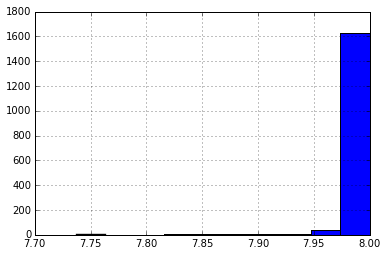

In [50]:
# Query the network
# df_full[(df_full['State1'] == 'Interior Alaska') & (df_full['State1'] != df_full['State2'])]
# df_full[(df_full['State1'] == 'Alberta') | (df_full['State2'] == 'Alberta')]
# df_full[(df_full['State1'] != df_full['State2']) & (df_full['Time Delta'] > 15)]['Time Delta'].hist()
df_full[(df_full['State1'] == df_full['State2']) & (df_full['Time Delta'] <= 15)]['Weight'].hist()
# df_full[df_full['State1'] != df_full['State2']].sort("Weight", ascending=False)['Weight'].hist()
# df_full[df_full['Weight'] >= 7.99]['Time Delta'].hist() # These are frozen passengers
# df_full[df_full['Time Delta'] > 300]['Weight'].hist()
# df_full[df_full['Subtype1'] != df_full['Subtype2']]
# df_full[df_full['Source'].str.contains("A/American black duck/New Brunswick/00476/2010")]

In [51]:
df_nodes[df_nodes['State2'] == 'Indiana']

,Host2,Isolate Name2,Isolation Date2,State2,Subtype2


In [52]:
# Create an undirected version of the transmission graph.
undirected_G = G.to_undirected()

# Make sure that the time deltas are all positive values.
for edge in undirected_G.edges(data=True):
    if edge[2]['time_delta'] < timedelta(0):
        edge[2]['time_delta'] = abs(edge[2]['time_delta'])

In [53]:
# Check the undiredcted_G edges:
undirected_G.nodes(data=True)

[('A/shorebird/Delaware Bay/331/2008',
  {'host': 'IRD:Shorebird/Avian',
   'isolation_date': Timestamp('2008-05-17 00:00:00'),
   'state': 'Delaware',
   'subtype': '(N6)'}),
 ('A/mallard/California/2542V/2011',
  {'host': 'IRD:Mallard/Avian',
   'isolation_date': Timestamp('2011-08-12 00:00:00'),
   'state': 'California',
   'subtype': 'H5N1'}),
 ('A/ruddy turnstone/Delaware/Sg-00472/2008',
  {'host': 'IRD:Ruddy Turnstone/Avian',
   'isolation_date': Timestamp('2008-05-21 00:00:00'),
   'state': 'Delaware',
   'subtype': 'H10N7'}),
 ('A/blue-winged teal/Nova Scotia/00079/2010',
  {'host': 'IRD:Avian',
   'isolation_date': Timestamp('2010-09-07 00:00:00'),
   'state': 'Nova Scotia',
   'subtype': 'H3N8'}),
 ('A/northern pintail/Interior Alaska/9BM6248R0/2009',
  {'host': 'IRD:Avian',
   'isolation_date': Timestamp('2009-08-03 00:00:00'),
   'state': 'Interior Alaska',
   'subtype': 'H4N6'}),
 ('A/American black duck/Wisconsin/11OS3191/2011',
  {'host': 'IRD:American Black Duck/Avian',

In [54]:
undir_nodes = pd.DataFrame()

for node in undirected_G.nodes(data=True):
    node_series = pd.Series()
    node_series['Isolate Name'] = node[0]
    node_series['State'] = node[1]['state']
    node_series['Subtype'] = node[1]['subtype']
    node_series['Host'] = node[1]['host']
    node_series['Isolation Date'] = node[1]['isolation_date']
    
    undir_nodes = undir_nodes.append(node_series, ignore_index=True)
    
undir_nodes['Isolation Date'] = undir_nodes['Isolation Date'].astype('datetime64[ns]')
undir_nodes.to_csv('3.10 - Full Transmission as CSV/Undirected Transmission Nodes.csv')

In [55]:
# Write CSV file of the undirected graph

undir_edges = pd.DataFrame()

for edge in undirected_G.edges(data=True):
    df_edge = pd.Series()
    df_edge['Isolate1'] = edge[0]
    df_edge['Isolate2'] = edge[1]
    df_edge['Transmission Type'] = edge[2]['trtype']        
    df_edge['Time Delta'] = edge[2]['time_delta']
    df_edge['Weight'] = edge[2]['weight']
    df_edge['Time Class'] = edge[2]['tr_timeclass']
   
    undir_edges = undir_edges.append(df_edge, ignore_index=True)
    
undir_edges.to_csv('3.10 - Full Transmission as CSV/Undirected Full Transmission Edges.csv')

In [56]:
# Modify the Nodes column names to fit with the undirected isolate1-isolate2 paradigm.
undir_nodes.columns = map(lambda x: x + '1', undir_nodes.columns)
print(undir_nodes.columns)

undir_graph = undir_edges.set_index('Isolate1').join(undir_nodes.set_index('Isolate Name1'))
undir_nodes.columns = map(lambda x: x.replace('1', '2'), undir_nodes.columns)
print(undir_nodes.columns)

undir_graph = undir_graph.reset_index()
print(undir_graph.columns)

undir_graph.columns = ['Isolate1' if item == 'index' else item for item in list(undir_graph.columns)]
print(undir_graph.columns)

undir_graph = undir_graph.set_index('Isolate2').join(undir_nodes.set_index('Isolate Name2'))
undir_graph = undir_graph.reset_index()
undir_graph.columns = ['Isolate2' if item == 'index' else item for item in list(undir_graph.columns)]
undir_graph.columns

undir_graph.to_csv('3.10 - Full Transmission as CSV/Undirected Full Transmissions.csv')

Index([u'Host1', u'Isolate Name1', u'Isolation Date1', u'State1', u'Subtype1'], dtype='object')
Index([u'Host2', u'Isolate Name2', u'Isolation Date2', u'State2', u'Subtype2'], dtype='object')
Index([u'index', u'Isolate2', u'Time Class', u'Time Delta', u'Transmission Type', u'Weight', u'Host1', u'Isolation Date1', u'State1', u'Subtype1'], dtype='object')
Index([u'Isolate1', u'Isolate2', u'Time Class', u'Time Delta', u'Transmission Type', u'Weight', u'Host1', u'Isolation Date1', u'State1', u'Subtype1'], dtype='object')


In [57]:
undir_graph[undir_graph['Time Delta'] < 2]

,Isolate2,Isolate1,Time Class,Time Delta,Transmission Type,Weight,Host1,Isolation Date1,State1,Subtype1,Host2,Isolation Date2,State2,Subtype2
0,A/American black duck/New Brunswick/00326/2010,A/mallard/New Brunswick/00324/2010,Direct Transmission,0,Intra-Species,7.998973,IRD:Avian,2010-08-08,New Brunswick,H1N1,IRD:Avian,2010-08-08,New Brunswick,H1N1
1,A/American black duck/New Brunswick/00326/2010,A/mallard/New Brunswick/00340/2010,Direct Transmission,0,Intra-Species,7.995057,IRD:Avian,2010-08-08,New Brunswick,H1N1,IRD:Avian,2010-08-08,New Brunswick,H1N1
2,A/American black duck/New Brunswick/00328/2010,A/green-winged teal/New Brunswick/00333/2010,Direct Transmission,0,Intra-Species,7.998774,IRD:Avian,2010-08-08,New Brunswick,H1N1,IRD:Avian,2010-08-08,New Brunswick,H1N1
3,A/American black duck/New Brunswick/00344/2010,A/mallard/Nova Scotia/00372/2010,Direct Transmission,0,Intra-Species,7.997784,IRD:Avian,2010-08-08,Nova Scotia,H7N7,IRD:Avian,2010-08-08,New Brunswick,H7N7
6,A/American black duck/New Brunswick/00425/2010,A/American black duck/New Brunswick/00424/2010,Direct Transmission,0,Intra-Species,7.998462,IRD:Avian,2010-08-10,New Brunswick,H3N8,IRD:Avian,2010-08-10,New Brunswick,H3N8
9,A/American black duck/New Brunswick/00468/2010,A/American black duck/New Brunswick/00464/2010,Direct Transmission,0,Intra-Species,7.992878,IRD:Avian,2010-08-12,New Brunswick,H4N6,IRD:Avian,2010-08-12,New Brunswick,H4N6
10,A/American black duck/New Brunswick/00468/2010,A/American black duck/New Brunswick/00469/2010,Direct Transmission,0,Intra-Species,7.996128,IRD:Avian,2010-08-12,New Brunswick,H4N6,IRD:Avian,2010-08-12,New Brunswick,H4N6
11,A/American black duck/New Brunswick/00468/2010,A/American black duck/New Brunswick/00472/2010,Direct Transmission,0,Intra-Species,7.998529,IRD:Avian,2010-08-12,New Brunswick,H4N6,IRD:Avian,2010-08-12,New Brunswick,H4N6
12,A/American black duck/New Brunswick/00468/2010,A/American black duck/New Brunswick/00481/2010,Direct Transmission,0,Intra-Species,7.997571,IRD:Avian,2010-08-12,New Brunswick,H4N6,IRD:Avian,2010-08-12,New Brunswick,H4N6
13,A/American black duck/New Brunswick/00468/2010,A/American black duck/New Brunswick/00499/2010,Direct Transmission,0,Intra-Species,7.996645,IRD:Avian,2010-08-12,New Brunswick,H4N6,IRD:Avian,2010-08-12,New Brunswick,H4N6


In [58]:
# Undirected version should have only 1213 edges.
# 22 September 2014: Update - with 2011 isolates removed, there are only 1210. This is consistent with Nichola removing 
# 3 edges as a result of 2011 isolates being present.
# 23 September 2014: Expanded 2008-2011 dataset has 1704 edges.
len(undirected_G.edges())

1749

In [59]:
# Open up the lat/long values
lat_long_vals = pd.read_csv('lat_long.csv')
lat_long_vals

,State,N,W
0,Alberta,55.0000,115.0000
1,Arkansas,34.8000,92.2000
2,California,37.0000,120.0000
3,Delaware,39.0000,75.5000
4,Delaware Bay,39.0000,75.5000
5,Guatemala,14.6000,90.5000
6,Illinois,40.0000,89.0000
7,Indiana,40.0000,86.0000
8,Interior Alaska,64.8436,147.7231
9,Iowa,42.0000,93.0000


In [60]:
# Do a bunch of checks on the graph:

# 1. There should be no isolation dates < 1 Jan 2008
# df_full[df_full['Isolation Date1'] < datetime(2008, 1, 1)]
# df_full[df_full['Isolation Date2'] < datetime(2008, 1, 1)]

# 2. There should be no isolation dates > 31 Dec 2011
# df_full[df_full['Isolation Date1'] > datetime(2012, 12, 31)]
# df_full[df_full['Isolation Date2'] > datetime(2012, 12, 31)]

# 3. Time deltas should be no smaller than -6.
# df_full[df_full['Time Delta'] < -6]

# 4. Number of rows present in df_full should equal the number of edges in the directed graph.
# len(G.edges()) == len(df_full)

# 5. Number of rows present in undir_graph should equal the number of edges in G.to_undirected()
# len(G.to_undirected().edges()) == len(undir_graph)

# 6. Number of Interior Alaska isolates present should be equal.
# len(undir_nodes[undir_nodes['State2'] == 'Interior Alaska']) == len([node for node in G.nodes(data=True) if node[1]['state'] == 'Interior Alaska'])

# 7. Identify the number of Brandt's 2009 and 2010 isolates that finally made it into the network.
brandt_data = pd.read_csv('Raw Data/20140206 Minto Flats 520 with Accessions.csv', index_col='Sample ID', parse_dates=['Date'])
brandt_isolates = set(brandt_data['Common Name'].str.split('(').str[0].values) #set of isolate names
brandt_lowquality = set(brandt_data[brandt_data['Sequence Accession'].str.contains("\*")]['Common Name'].str.split("(").str[0].values)
graph_isolates = set([node[0] for node in G.nodes(data=True) if node[0].split('/')[2] == 'Interior Alaska'])

# The number of 2009 and 2010 isoaltes that made it into the network is 504:
len(graph_isolates.intersection(brandt_isolates))

# This is out of a total of 516 isolates.

### The following isolates have been removed due to low quality in segment 1, and number 12 isolates.
print((brandt_isolates - graph_isolates).intersection(brandt_lowquality) == brandt_lowquality)
print(len((brandt_isolates - graph_isolates).intersection(brandt_lowquality)))

True
12


['Alberta' 'Arkansas' 'California' 'Canada' 'Delaware' 'Guatemala'
 'Illinois' 'Interior Alaska' 'Iowa' 'Louisiana' 'Maine' 'Manitoba'
 'Michigan' 'Minnesota' 'Mississippi' 'Missouri' 'New Brunswick'
 'New Jersey' 'North Dakota' 'Nova Scotia' 'Nunavut' 'Ohio' 'Ontario'
 'Prince Edward Island' 'Quebec' 'Southeastern Alaska' 'Texas' 'Wisconsin']
Canada {'W': 75.67, 'N': 45.4}
Mississippi {'W': 90.0, 'N': 33.0}
Ontario {'W': 85.0, 'N': 50.0}
Delaware {'W': 75.5, 'N': 39.0}
Minnesota {'W': 94.0, 'N': 46.0}
Illinois {'W': 89.0, 'N': 40.0}
Arkansas {'W': 92.2, 'N': 34.8}
Alberta {'W': 115.0, 'N': 55.0}
Louisiana {'W': 91.836, 'N': 31.0413}
Texas {'W': 100.0, 'N': 31.0}
Wisconsin {'W': 89.5, 'N': 44.5}
Iowa {'W': 93.0, 'N': 42.0}
Michigan {'W': 85.0102, 'N': 43.6867}
Prince Edward Island {'W': 63.0, 'N': 46.2}
Guatemala {'W': 90.5, 'N': 14.6}
California {'W': 120.0, 'N': 37.0}
Interior Alaska {'W': 147.7231, 'N': 64.8436}
Nunavut {'W': 91.0, 'N': 73.0}
North Dakota {'W': 100.0, 'N': 47.0}
Nov

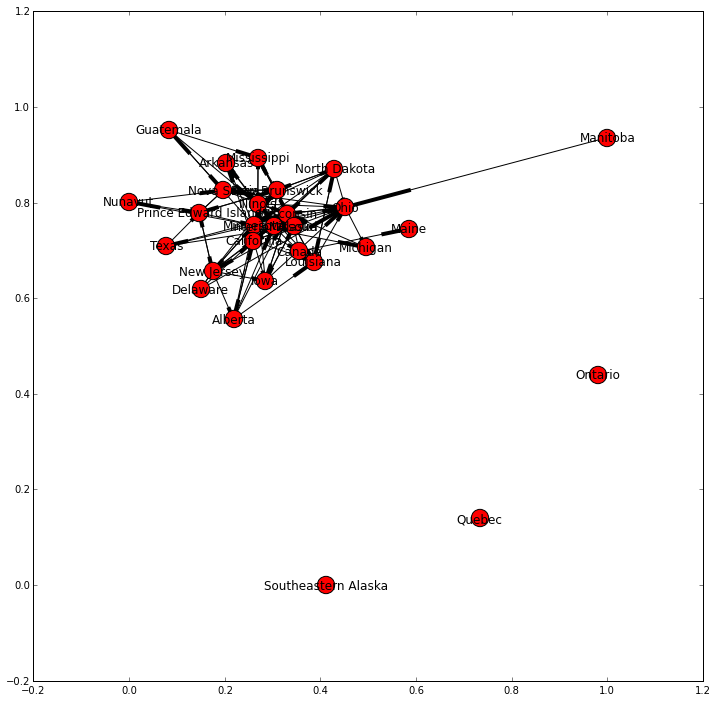

In [61]:
# Create a graph based on geography

geonet = nx.DiGraph()

year = df_full

# Add in the nodes 

geographic_locations = np.unique(year[['State1', 'State2']].values)
print(geographic_locations)

for place in geographic_locations:
    geonet.add_node(place)

# Add in the edges with initial weights 0

for row in year.iterrows():
    geonet.add_edge(row[1]['State1'], row[1]['State2'], weight=0, num_connections=0)

# Add in the weights

for row in year.iterrows():
    if geonet.has_edge(row[1]['State1'], row[1]['State2']):
        geonet[row[1]['State1']][row[1]['State2']]['weight'] += row[1]['Weight']
        geonet[row[1]['State1']][row[1]['State2']]['num_connections'] += 1
        
# Add in lat-long data for each state
for row in lat_long_vals.iterrows():
    if row[1]['State'] in geonet.nodes():
        geonet.node[row[1]['State']]['N'] = row[1]['N']
        geonet.node[row[1]['State']]['W'] = row[1]['W']
        
# Check to make sure that every geonet node has an 'n' and 'w' value:
for node, data in geonet.nodes(data=True):
    print node, data

fig = plt.figure(figsize=(12,12))
nx.draw_networkx(geonet)

d = json_graph.node_link_data(geonet) # node-link format to serialize
json.dump(d, open('viz/geonet.json','w'))

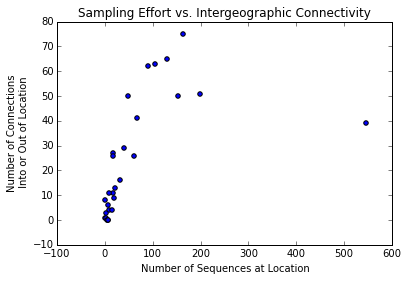

In [62]:
# We want to know if sampling effort, as measured by no. of molecular sequences obtained, is related to the 
# strength of connectivity to AK.

# Let's query the graph by asking if the number of sequences present in AK-connected sites is related
# to the weight between AK and that site.

ak_connected_edges = []
for edge in geonet.edges(data=True):
    if 'Interior Alaska' in edge[0] or 'Interior Alaska' in edge[1]:
        ak_connected_edges.append(edge)
        
# Now, let's grab out the non-IAK site names and pair them with the weights, then cast it as a dataframe.

# site_weight = dict()
# for edge in ak_connected_edges:
#     if edge[0] != 'Interior Alaska':
#         site_weight[edge[0]] = edge[2]['weight']
#     if edge[1] != 'Interior Alaska':
#         site_weight[edge[1]] = edge[2]['weight']

# Just as a backup, do it with all possible edges.
site_weight = dict()
for edge in geonet.edges(data=True):
    site_weight[edge[0]] = 0
    site_weight[edge[1]] = 0
    
for edge in geonet.edges(data=True):
    if edge[0] != edge[1]:
        site_weight[edge[0]] += edge[2]['weight']
        site_weight[edge[1]] += edge[2]['weight']
    
# Create a dataframe with the state name and weight
site_weight_df = pd.DataFrame(zip(site_weight.keys(), site_weight.values()))
site_weight_df.columns = ['site', 'weight']
site_weight_df.set_index('site', inplace=True)
site_weight_df['weight'] = site_weight_df['weight'].apply(lambda x: math.ceil(x/8))

# Let's open up the old datafile that contains all the info and grab out # of sequences from those sites.
raw_data = pd.read_csv('3.10 - Full Transmission as CSV/Undirected Transmission Nodes.csv', index_col=0)
raw_data.replace("SK", "Saskatchewan", inplace=True)
raw_counted = raw_data.groupby('State').count()
raw_counted

# Do a join to bring in the counts into site_weight_df

joined = site_weight_df.join(raw_counted, how='outer')
# joined
joined['counts'] = joined['Isolation Date']
del joined['Isolation Date']

plt.scatter(joined['counts'], joined['weight'])
plt.ylabel('Number of Connections \n Into or Out of Location')
plt.xlabel('Number of Sequences at Location')
plt.title("Sampling Effort vs. Intergeographic Connectivity")
# plt.xlim([0, 250])
plt.savefig('Sampling Effort vs. Intergeographic Connectivity.pdf')

joined.to_csv('Sampling Effort vs. Intergeographic Connectivity.csv')

In [63]:
# Calculate probability of getting n cross-population edges by random, where n <= num_cross_pop_edges
# This effectively constitutes our statistical test of significance. 
def prob_cross_pop(a_pop, b_pop, n):
    """
    a_pop = size of population A
    b_pop = size of population B
    n = number of cross population edges
    """
    if n == 0 or n > a_pop * b_pop:
        return 0
    else:
        total_edges = np.sum([i for i in range(sum([a_pop, b_pop]))])
        total_cross_pop = a_pop * b_pop

        total_probability = 1
        for i in range(n):
            total_probability = total_probability * ((total_cross_pop - i) / (total_edges - i))

        return total_probability

In [64]:
# Let's calculate the probability of connectivity by chance.

# Firstly, update geonet's nodes with the number of isolates:
for node in geonet.nodes(data=True):
    node[1]['sample_size'] = int(joined.ix[node[0]]['counts'])
    
# Next, we calculate the probability of having that number of cross-population edges for every edge in geonet.
for edge in geonet.edges(data=True):
    if edge[0] == edge[1]:
        edge[2]['cross_population_likelihood'] = 0
    if edge[0] != edge[1]:
        a_pop = geonet.node[edge[0]]['sample_size']
        b_pop = geonet.node[edge[1]]['sample_size']
        n = edge[2]['num_connections']
        
        edge[2]['cross_population_likelihood'] = prob_cross_pop(a_pop, b_pop, n)
        
geonet.edges(data=True)

[('Canada',
  'Canada',
  {'cross_population_likelihood': 0,
   'num_connections': 16,
   'weight': 127.95061}),
 ('Canada',
  'Maine',
  {'cross_population_likelihood': 0.086956521739130432,
   'num_connections': 1,
   'weight': 7.997908}),
 ('Mississippi',
  'Mississippi',
  {'cross_population_likelihood': 0,
   'num_connections': 11,
   'weight': 87.540231}),
 ('Mississippi',
  'Wisconsin',
  {'cross_population_likelihood': 0.082737141298289074,
   'num_connections': 2,
   'weight': 15.439629}),
 ('Mississippi',
  'New Brunswick',
  {'cross_population_likelihood': 0.032904625640960312,
   'num_connections': 3,
   'weight': 23.47784}),
 ('Mississippi',
  'Illinois',
  {'cross_population_likelihood': 0.08488390455530466,
   'num_connections': 3,
   'weight': 23.596396}),
 ('Ontario',
  'Ontario',
  {'cross_population_likelihood': 0,
   'num_connections': 1,
   'weight': 7.974877999999999}),
 ('Delaware',
  'New Jersey',
  {'cross_population_likelihood': 1.6073662366131781e-11,
   'num

In [65]:
# Create a pandas DataFrame with the geographic sites, number of connections, total weight, and likelihood.
geonet_likelihood_df = pd.DataFrame()
for edge in geonet.edges(data=True):
    row = pd.Series()
    
    row['Site 1'] = edge[0]
    row['Site 2'] = edge[1]
    
    row['Sum of Weights'] = edge[2]['weight']
    row['Number of Connections'] = edge[2]['num_connections']
    row['Probability Value'] = edge[2]['cross_population_likelihood']
    
    geonet_likelihood_df = geonet_likelihood_df.append(row, ignore_index=True)
    
geonet_likelihood_df.to_csv('3.10 - Full Transmission as CSV/Geonet Likelihood.csv')

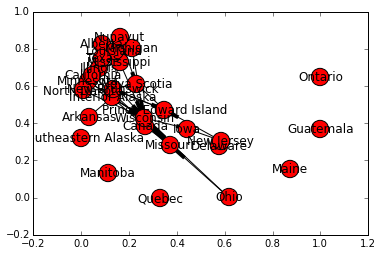

In [66]:
# Let's create a filtered version of geonet, in which the likelihood of cross-population edges by random chance is 
# less than 0.05
alpha_value = 0.05

geonet_filtered = geonet.copy()
for edge in geonet_filtered.edges(data=True):
    if edge[2]['cross_population_likelihood'] > alpha_value:
#         print(edge)
        geonet_filtered.remove_edge(edge[0], edge[1])
        
# geonet_filtered.edges(data=True)
nx.draw_networkx(geonet_filtered)
d = json_graph.node_link_data(geonet_filtered) # node-link format to serialize
json.dump(d, open('viz/geonet_filtered.json','w'))

In [67]:
#HELLO
print("Hello")

Hello
